In [4]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [5]:
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = Image.open(img_path).convert('L')
        img = img.resize((128, 128))
        img_array = np.array(img)
        images.append(img_array)
        labels.append(label)
    return images, labels

In [6]:
no_images, no_labels = load_images_from_folder('Brain Tumor Dataset/no', 0)
yes_images, yes_labels = load_images_from_folder('Brain Tumor Dataset/yes', 1)

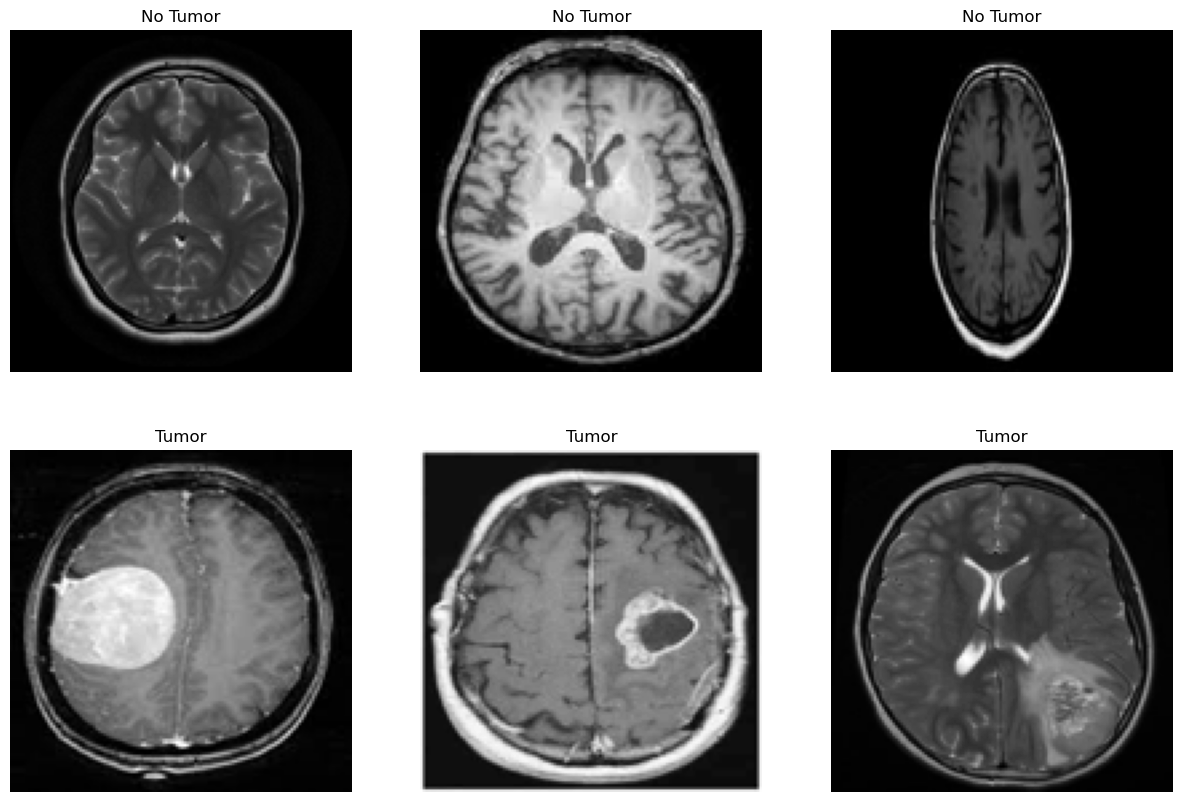

In [7]:
# visualize three images from each class
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i in range(3):
    axs[0, i].imshow(no_images[i], cmap='gray')
    axs[0, i].set_title('No Tumor')
    axs[0, i].axis('off')
    axs[1, i].imshow(yes_images[i], cmap='gray')
    axs[1, i].set_title('Tumor')
    axs[1, i].axis('off')

In [8]:
# combine the images and labels
images = no_images + yes_images
labels = no_labels + yes_labels

# Augment the images by flipping them horizontally
augmented_images = []
augmented_labels = []
for i in range(len(images)):
    augmented_images.append(images[i])
    augmented_labels.append(labels[i])
    augmented_images.append(np.fliplr(images[i]))
    augmented_labels.append(labels[i])

In [9]:
# convert the images and labels to numpy arrays
images = np.array(augmented_images)
labels = np.array(augmented_labels)

# encode the labels to categorical
labels = to_categorical(labels)

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2)

In [10]:
X_train[0].shape

(128, 128)

In [29]:
# Define the CNN model
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(2, activation='softmax')
])

# Define optimizer
optimizer = tf.keras.optimizers.Adam(0.0001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
# Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train.reshape(-1, 128, 128, 1), y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
11/11 [==============================] - 4s 326ms/step - loss: 27.9525 - accuracy: 0.5913 - val_loss: 12.8546 - val_accuracy: 0.8148
Epoch 2/100
11/11 [==============================] - 3s 291ms/step - loss: 14.7160 - accuracy: 0.7337 - val_loss: 11.9912 - val_accuracy: 0.8148
Epoch 3/100
11/11 [==============================] - 4s 330ms/step - loss: 11.2955 - accuracy: 0.7276 - val_loss: 19.9830 - val_accuracy: 0.7531
Epoch 4/100
11/11 [==============================] - 4s 370ms/step - loss: 10.1093 - accuracy: 0.7337 - val_loss: 7.8372 - val_accuracy: 0.8765
Epoch 5/100
11/11 [==============================] - 3s 294ms/step - loss: 3.0352 - accuracy: 0.8297 - val_loss: 5.9614 - val_accuracy: 0.8765
Epoch 6/100
11/11 [==============================] - 3s 262ms/step - loss: 0.6463 - accuracy: 0.9195 - val_loss: 5.2052 - val_accuracy: 0.7284
Epoch 7/100
11/11 [==============================] - 3s 266ms/step - loss: 0.4328 - accuracy: 0.9536 - val_loss: 4.4760 - val_accuracy:

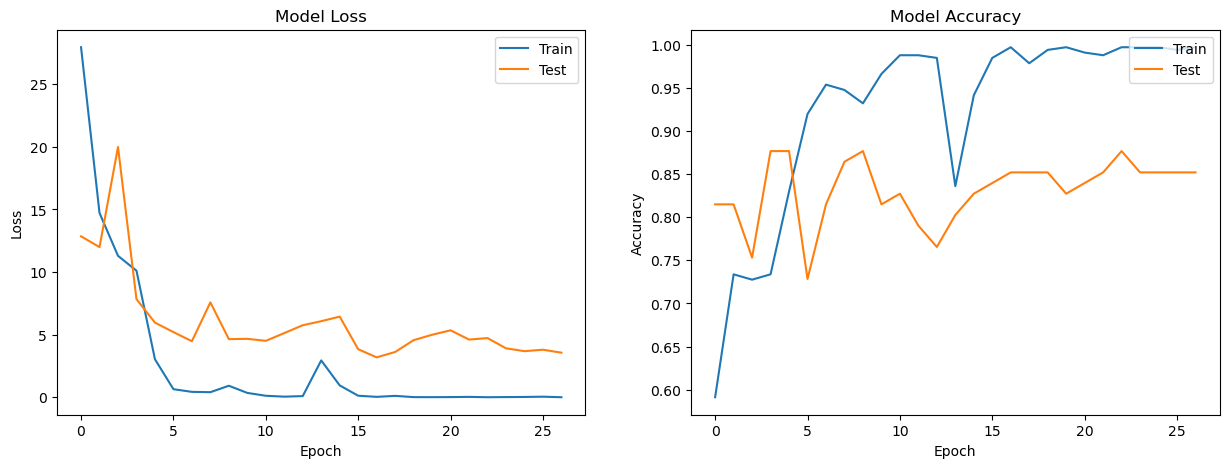

In [31]:
# plot the training loss and accuracy side by side
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

plt.show()

In [32]:
# Evaluate the model
model.evaluate(X_test.reshape(-1, 128, 128, 1), y_test)

4/4 [==============================] - 0s 67ms/step - loss: 1.6091 - accuracy: 0.8725


[1.6091207265853882, 0.8725489974021912]

In [33]:
# Save the model
model.save('brain_tumor_cnn.h5')
print('Model saved as brain_tumor_cnn.h5')

Model saved as brain_tumor_cnn.h5


In [2]:
# Load the model
model = tf.keras.models.load_model('brain_tumor_cnn.h5')
print('Model loaded successfully')

Model loaded successfully


4/4 [==============================] - 1s 72ms/step


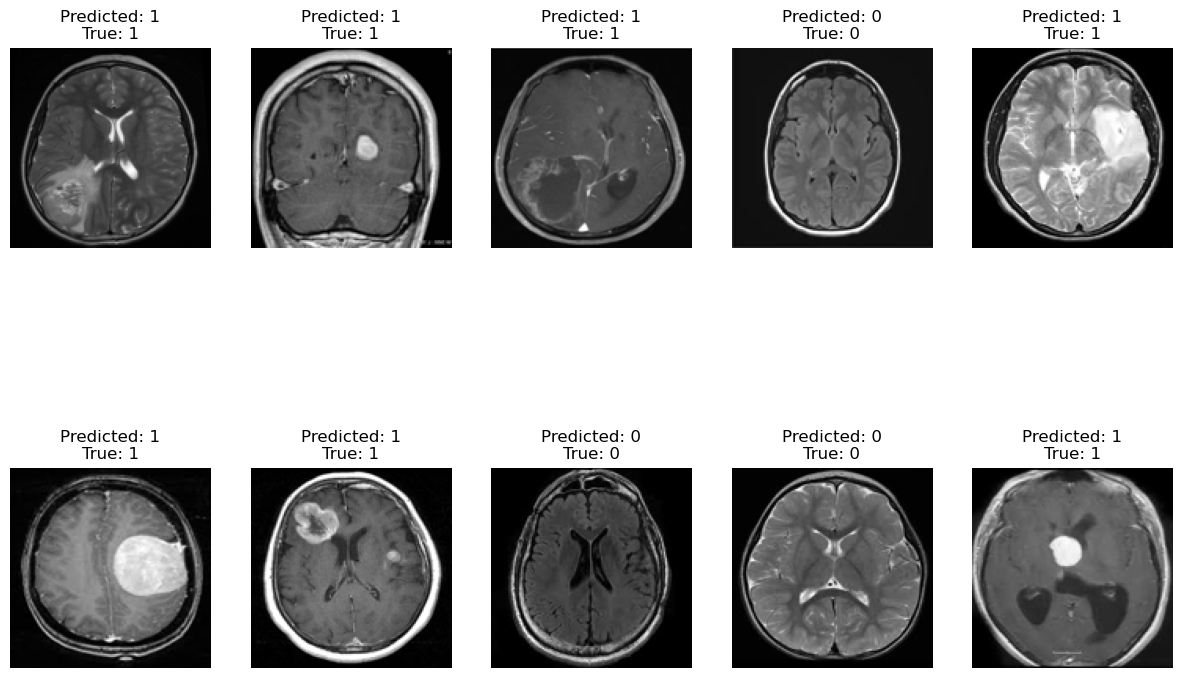

In [11]:
# Test the model
predictions = model.predict(X_test.reshape(-1, 128, 128, 1))
predictions = np.argmax(predictions, axis=1)

# Plot the first 10 test images with their predicted labels and true labels
plt.figure(figsize=(15, 10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[i], cmap='gray')
    plt.title(f'Predicted: {predictions[i]}\nTrue: {np.argmax(y_test[i])}')
    plt.axis('off')
    
plt.show()

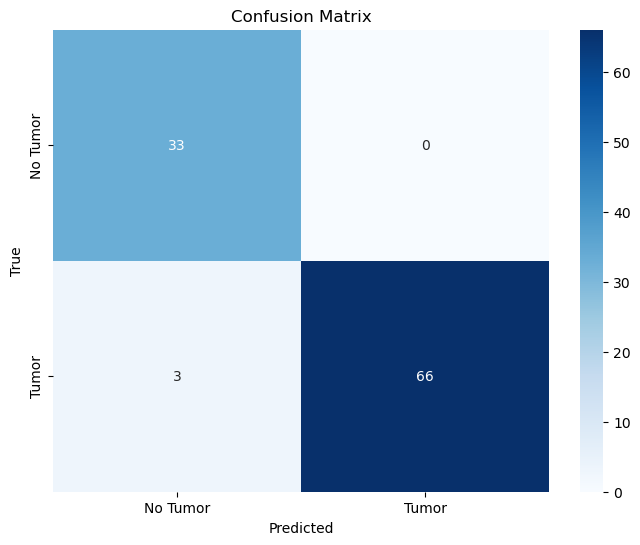

In [16]:
# Visualize the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()